In [42]:
import cv2
import numpy as np
from tqdm import tqdm

# ori_img = "snow.jpeg"
# output_video = "out.mp4"
# data_sequence = [0, 1, 0, 1, 1, 0, 0, 1, 0, 0]

# for sanity check
tmp_img = "tmp.jpeg"

def make_delta_alpha_image(base_image, delta_alpha):
    """
    Assume base_image of type uint8_t
    """
    base_image = base_image.astype(float)
    altered_image = np.multiply(base_image, 1 - delta_alpha)
    return altered_image.astype(np.uint8)

def make_fm_sequence(data_sequence):
    fm_1 = [0, 1, 0, 1, 0, 1]  # 30 Hz of 1s
    fm_0 = [0, 0, 1, 0, 0, 1]  # 20 Hz of 1s
    output_fm_sequence = []
    for i in data_sequence:
        if i == 1:
            output_fm_sequence.extend(fm_1)
        else:
            output_fm_sequence.extend(fm_0)
    return output_fm_sequence

def make_video(output_video, fm_sequence, image_0, image_1, constant_sequence_len=5):
    height, width, channels = image_0.shape
    video = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'MJPG'), 60, (width, height))

    # append some constant image for warm-up
    dark_image = (image_0 * .3).astype(np.uint8)
    for i in tqdm(range(constant_sequence_len)):
        video.write(dark_image)

    for i in tqdm(fm_sequence):
        curr_img = image_0 if i == 0 else image_1
        video.write(curr_img)

    # append some constant image for shut-down
    for i in tqdm(range(constant_sequence_len)):
        video.write(dark_image)

    video.release()

def run(image_name, output_name, data_sequence, delta_alpha=0.1):
    ori_img = cv2.imread(image_name)
    delta_alpha_img = make_delta_alpha_image(ori_img, delta_alpha)
    cv2.imwrite(tmp_img, delta_alpha_img)
    
    fm_sequence = make_fm_sequence(data_sequence)
    assert len(fm_sequence) == len(data_sequence) * 6

    make_video(output_name, fm_sequence, ori_img, delta_alpha_img)

# note that data_sequences is a list of list, each containing a fm_sequence
def run_multiple_sequence(image_name, output_name, data_sequences, delta_alpha=0.1, constant_sequence_len=10):
    ori_img = cv2.imread(image_name)
    delta_alpha_img = make_delta_alpha_image(ori_img, delta_alpha)
    cv2.imwrite(tmp_img, delta_alpha_img)

    fm_sequences = [make_fm_sequence(i) for i in data_sequences]
    
    ########################## make video #######################################
    height, width, channels = ori_img.shape
    video = cv2.VideoWriter(output_name, cv2.VideoWriter_fourcc(*'MJPG'), 60, (width, height))

    for seq in tqdm(fm_sequences):
        # append some constant image for warm-up
        dark_image = ori_img # (ori_img * .3).astype(np.uint8)
        for i in range(constant_sequence_len):
            video.write(dark_image)

        for i in seq:
            curr_img = ori_img if i == 0 else delta_alpha_img
            video.write(curr_img)

        # append some constant image for shut-down
        for i in range(constant_sequence_len):
            video.write(dark_image)

    video.release()

In [39]:
# [3 x preamble, 7 x data_bit, 1 x parity_bit]
run_multiple_sequence("snow.jpeg", "example2_wth_const.mp4", [[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]])

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


In [44]:
import random

# preamble is 010
# [3 x preamble, 7 x data_bit, 1 x parity_bit]
def make_random_sequences(n_seq, seq_len=8):
    all_seq = []
    for i in range(n_seq):
        all_seq.append([0, 1, 0] + random.choices([0, 1], k=seq_len))
    
    # assert parity
    for seq_i in all_seq:
        parity_bit = sum(seq_i[3:-1]) % 2
        seq_i[-1] = parity_bit

    return all_seq

In [45]:
data_sequences = make_random_sequences(10)
data_sequences

[[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1],
 [0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
 [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1],
 [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
 [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]]

In [64]:
run_multiple_sequence("snow.jpeg", "multi_3_05.mp4", data_sequences, delta_alpha=0.5)

100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


In [57]:
correct_data_sequences = [i[3:] for i in data_sequences]

## Evaluation

In [58]:
def accuracy_for_one(correct_data_sequences, input_sequences):
    all_result = []
    for seq_i in input_sequences:
        seq_i_results = []
        for seq_j in correct_data_sequences:
            # number of bits that is correct
            seq_i_results.append(len([(i, j) for i, j in zip(seq_i, seq_j) if i==j]))
        all_result.append(max(seq_i_results) / len(seq_i))
    
    top_all_result = sorted(all_result, reverse=True)[:len(correct_data_sequences)]
    return sum(top_all_result) / len(top_all_result)

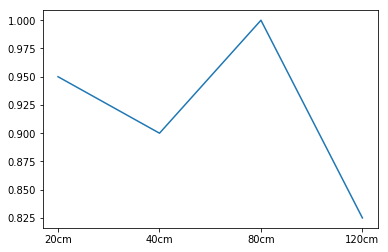

In [63]:
import matplotlib.pyplot as plt
accu_delta_1_20 = accuracy_for_one(correct_data_sequences, delta_1_20)
accu_delta_1_40 = accuracy_for_one(correct_data_sequences, delta_1_40)
accu_delta_1_80 = accuracy_for_one(correct_data_sequences, delta_1_80)
accu_delta_1_120 = accuracy_for_one(correct_data_sequences, delta_1_120)
plt.plot(["20cm", "40cm", "80cm", "120cm"], [accu_delta_1_20, accu_delta_1_40, accu_delta_1_80, accu_delta_1_120])

In [48]:
delta_1_20 = \
    [[0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 0, 1, 1, 1, 1],
    [0, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 0, 1, 0]]

delta_1_40 = \
    [[1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 1, 1],
    [0, 1, 1, 1, 0, 0, 1, 1],
    [0, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0]]

delta_1_80 = \
    [[0, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 0, 1, 1, 1, 1],
    [0, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0]]

delta_1_120 = \
    [[0, 1, 0, 1, 0, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 1],
    [0, 0, 1, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 1, 0, 1, 1, 0, 1]]

## Create darkened image

In [2]:
ori_img = cv2.imread(ori_img)
delta_alpha_img = make_delta_alpha_image(ori_img, 0.1)
# save temporary image to double check
cv2.imwrite(tmp_img, delta_alpha_img)

True

## Create video from modified image

In [4]:
fm_sequence = make_fm_sequence(data_sequence)
assert len(fm_sequence) == len(data_sequence) * 6

60

In [5]:
make_video(fm_sequence, ori_img, delta_alpha_img)

100%|██████████| 60/60 [00:01<00:00, 36.67it/s]


## Now, double check to make sure we have it correctly

In [21]:
def read_in_video(video_file_name):
    tot_frames = []
    cap = cv2.VideoCapture(video_file_name)
    while not cap.isOpened():
        cap = cv2.VideoCapture(video_file_name)
        cv2.waitKey(1000)
        print("Wait for the header")

    pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    while True:
        flag, frame = cap.read()
        if flag:
            # The frame is ready and already captured
            tot_frames.append(frame)
            # cv2.imshow('video', frame)
            pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
            print(str(pos_frame)+" frames")
        else:
            # The next frame is not ready, so we try to read it again
            cap.set(cv2.CAP_PROP_POS_FRAMES, pos_frame-1)
            print("frame is not ready")
            # It is better to wait for a while for the next frame to be ready
            cv2.waitKey(1000)

        if cv2.waitKey(10) == 27:
            break
        if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
            # If the number of captured frames is equal to the total number of frames,
            # we stop
            break
    return tot_frames

In [22]:
all_frames = read_in_video("out.avi")

1.0 frames
2.0 frames
3.0 frames
4.0 frames
5.0 frames
6.0 frames
7.0 frames
8.0 frames
9.0 frames
10.0 frames
11.0 frames
12.0 frames
13.0 frames
14.0 frames
15.0 frames
16.0 frames
17.0 frames
18.0 frames
19.0 frames
20.0 frames
21.0 frames
22.0 frames
23.0 frames
24.0 frames
25.0 frames
26.0 frames
27.0 frames
28.0 frames
29.0 frames
30.0 frames
31.0 frames
32.0 frames
33.0 frames
34.0 frames
35.0 frames
36.0 frames
37.0 frames
38.0 frames
39.0 frames
40.0 frames
41.0 frames
42.0 frames
43.0 frames
44.0 frames
45.0 frames
46.0 frames
47.0 frames
48.0 frames
49.0 frames
50.0 frames
51.0 frames
52.0 frames
53.0 frames
54.0 frames
55.0 frames
56.0 frames
57.0 frames
58.0 frames
59.0 frames
60.0 frames


In [25]:
for index, i in enumerate(all_frames):
    print(index, np.average(i))

0 111.14136262341111
1 111.14819157717538
2 99.57841166473692
3 111.10759690358151
4 111.11219191156576
5 99.55416127447664
6 111.12308423902232
7 99.56107573237628
8 111.12591917981682
9 99.56422678564797
10 111.1273225998496
11 99.56396639799385
12 111.18755883331079
13 111.18748856076522
14 99.58469116221299
15 111.11123549206614
16 111.11655212511141
17 99.55951375874687
18 111.12702689977506
19 99.56682890071275
20 111.1316887195219
21 99.56768346543163
22 111.13089238713951
23 99.56876430733278
24 111.18755883331079
25 99.56591703620369
26 111.13607288914619
27 99.57021008569147
28 111.13771305160321
29 99.57175487974546
30 111.13601598309778
31 111.13078578673421
32 99.59526254867477
33 111.11494978258823
34 111.11874727696477
35 99.56375197451139
36 111.18755883331079
37 111.18747587813534
38 99.58469029183644
39 111.11123016619052
40 111.11655626976169
41 99.55951518865122
42 111.1270237705641
43 99.5668340815256
44 111.1316966979737
45 99.56768864624448
46 111.13090036559132
